# Glacial Hydraulic Tremor

## Importing modules and libraries

### Importing libraries

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy
import math
import datetime
import time
import obspy

### Give access to modules folder

In [2]:
import os, sys
modules = os.path.abspath('Modules//')
if modules not in sys.path:
    sys.path.append(modules)

### Importing homemade python modules

In [3]:
from hydronoise import hydronoise_plot
from hydronoise import amp_noise_mean_median

In [4]:
from normalize import normalize

## Importing data from gauging station and temperature

### Specify the folder of temperature and discharge data

In [5]:
direct = 'E:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V299\Vdv_data_20221120143940'

### Importing temperature and discharge data

In [6]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

### Plotting temperature and discharge data

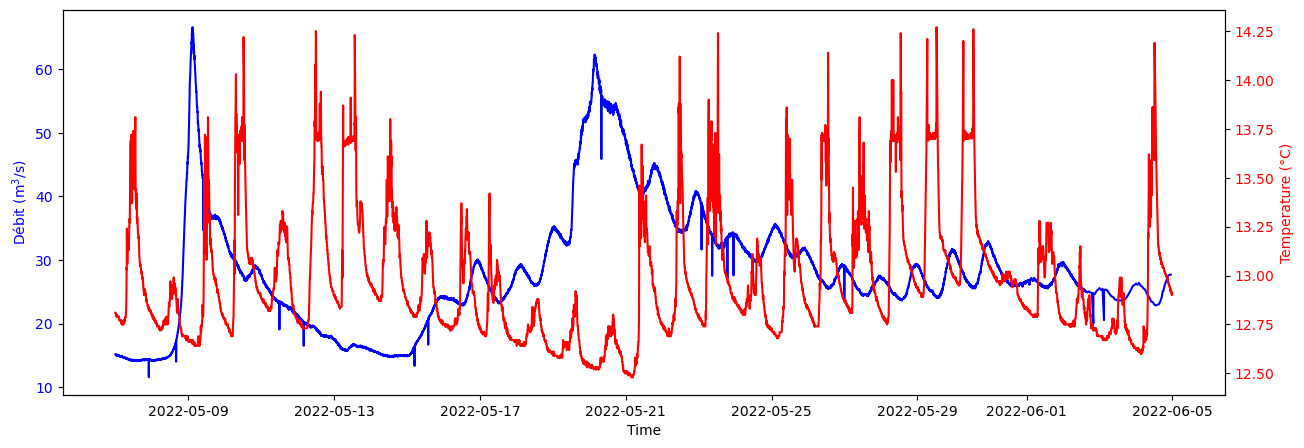

In [7]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
#Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Temperature (°C)', color = 'red') 
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
#Show plot

plt.show()

In [13]:
gauging_time[np.argmax(gauging_velos)]

datetime.datetime(2022, 5, 9, 2, 45)

In [14]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-288:i]) + (i-288)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

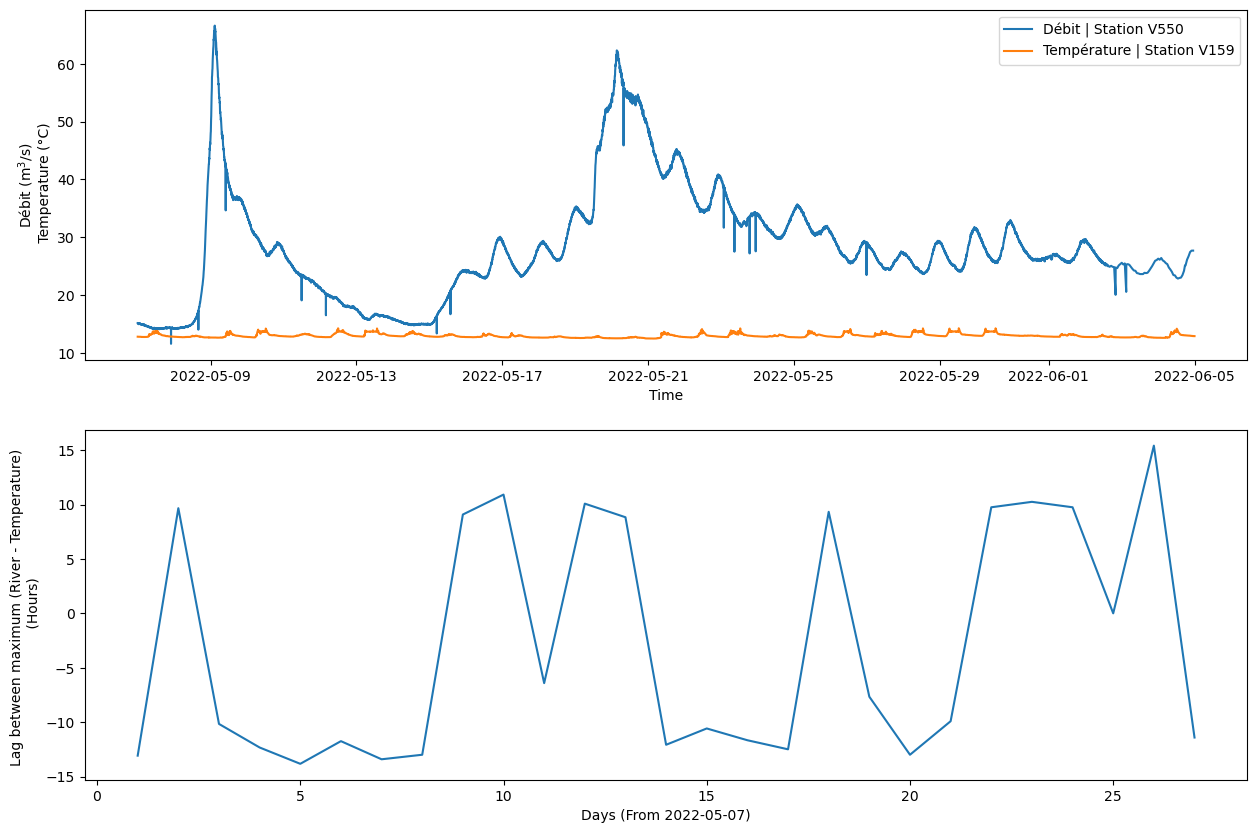

In [15]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

### Importing temperature and precipitation from NetCFDmport netCDF4

In [16]:
import netCDF4 as nc

In [17]:
import numpy as np

# Thanks to unutbu

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [18]:
data = './temp-precip/era5-island.nc'
ds = nc.Dataset(data)

In [19]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-03-21 16:44:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1679417074.8680806-11952-13-0535f1b1-ae53-430f-bd02-a41c35b01720.nc /cache/tmp/0535f1b1-ae53-430f-bd02-a41c35b01720-adaptor.mars.internal-1679416861.7139752-11952-8-tmp.grib
    dimensions(sizes): longitude(53), latitude(17), time(744)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 ptype(time, latitude, longitude), int16 sst(time, latitude, longitude), int16 rsn(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [20]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-03-21 16:44:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1679417074.8680806-11952-13-0535f1b1-ae53-430f-bd02-a41c35b01720.nc /cache/tmp/0535f1b1-ae53-430f-bd02-a41c35b01720-adaptor.mars.internal-1679416861.7139752-11952-8-tmp.grib'}


In [21]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:])
temp = np.array(ds['t2m'][:])

In [22]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
Tcfd = []
for h in time :
    Tcfd.append(origin + datetime.timedelta(hours = float(h)))

In [23]:
lat = 64.209114
lon = -17.832866
PREP = []
TEMP = []

idxLat = find_nearest(LAT, lat)
idxLong = find_nearest(LON, lon)

for t in range(len(time)) :
    PREP.append(float(prcp[t][idxLat][idxLong]))
    TEMP.append(float(temp[t][idxLat][idxLong]))

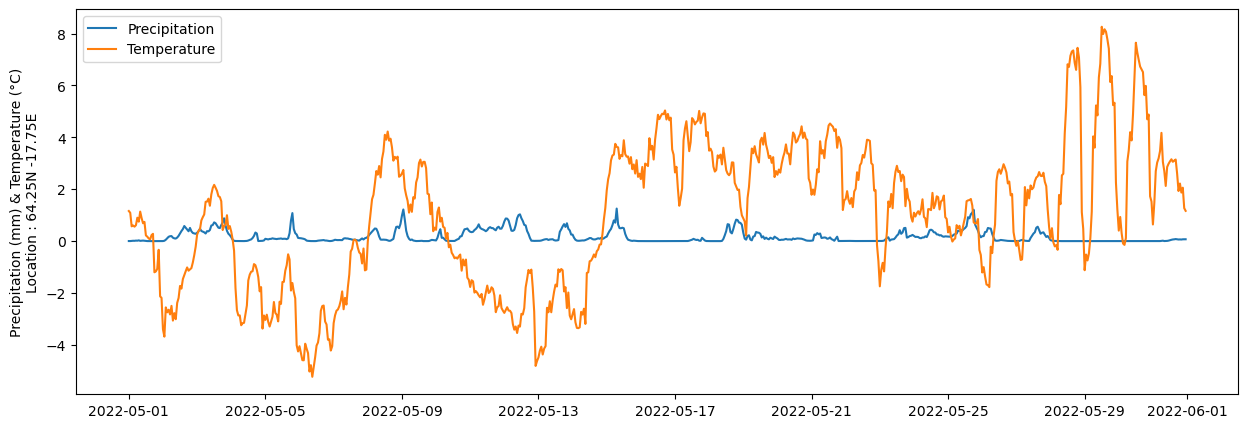

In [24]:
plt.figure(figsize=(15,5))
plt.plot(Tcfd,np.array(PREP)*1000, label='Precipitation')
plt.plot(Tcfd,np.array(TEMP)-273.25, label='Temperature')
plt.ylabel('Precipitation (mm) & Temperature (°C)\nLocation : %0.2fN %0.2fE' %(LAT[idxLat], LON[idxLong]))

plt.legend()

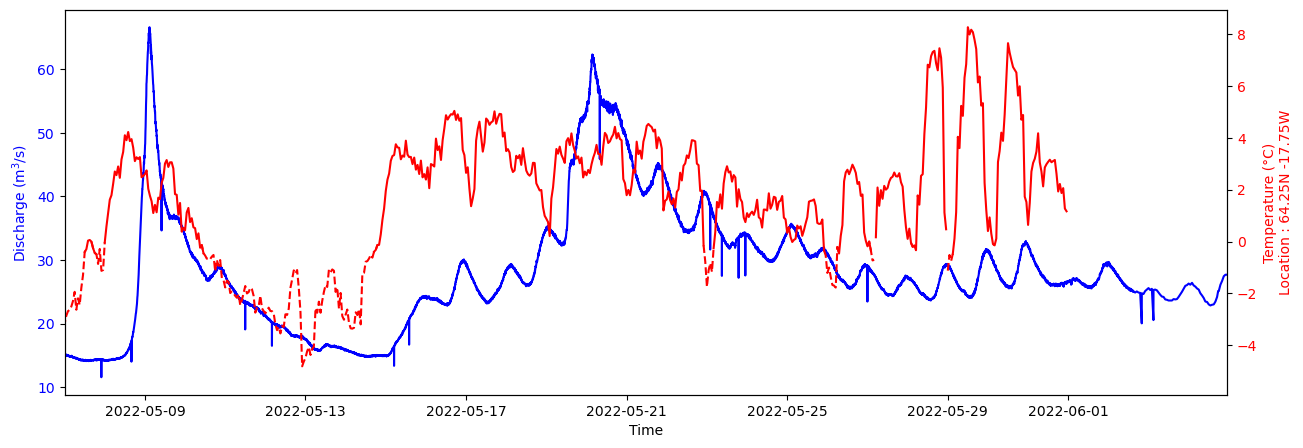

In [25]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Discharge (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
#Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Temperature (°C)\nLocation : %0.2fN %0.2fW'  %(LAT[idxLat], LON[idxLong]), color = 'red') 
ax2.plot(Tcfd,np.where(np.array(TEMP)-273.25 >= -0.5, np.array(TEMP)-273.25, np.nan) , label='Temperature',c='r')
ax2.plot(Tcfd,np.where(np.array(TEMP)-273.25 < 0, np.array(TEMP)-273.25, np.nan) , label='Temperature',c='r',ls='--')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
#Show plot
plt.xlim(gauging_time[0],gauging_time[-1])
plt.show()

# Confronting wave with water : PPSD

## Modules and fonctions

In [28]:
from obspy.signal import PPSD

In [29]:
"""
Fonction qui fait la mediane sur une succession de points
output[0] = median
output[1] = std
output[2] = time
"""
def medGPS_linear(rL, time,nbrpt = None) :
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[]] #0 is median
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            output[0].append(np.median(rL[i:i+nbrpt]))
            output[1].append(np.std(rL[i:i+nbrpt]))
            output[2].append(time[i])
    return np.array(output)

In [30]:
def RMS_smoothing(rL, time,nbrpt = None) :
    rL = np.array(rL)
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[],[]] #0 is rms
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            rms = np.sqrt(np.sum(rL[i:i+nbrpt]**2)/nbrpt)
            mode = scipy.stats.mode(rL[i:i+nbrpt],keepdims=True)[0][0]
            hist, bin_edges = np.histogram(rL[i:i+nbrpt], density=True)
            mode_np = hist.max()
            output[0].append(rms)
            output[1].append(mode)
            output[2].append(mode_np)
            output[3].append(time[i])
    return np.array(output)

### Defining the station xml

In [31]:
paz_counts = {'gain': 3355.4428,
       'poles': [(-22.2111-22.2178j),(-22.2111+22.2178j)],
       'sensitivity': 4910675.0731663825,
       'zeros': [0j, 0j]}

In [32]:
rot = "E:\\Nodes_ablation_zone\All_comp_DP_\\"
#rot = 'E:/Nodes_on_Vatna/All_comp_DP_/'
fileroot= os.listdir(rot)

### Processing PPSD for 1 geophone

1 Trace(s) in Stream:
SS.20739..DPZ | 2022-05-23T00:00:00.000000Z - 2022-05-24T00:00:00.000000Z | 250.0 Hz, 21600001 samples


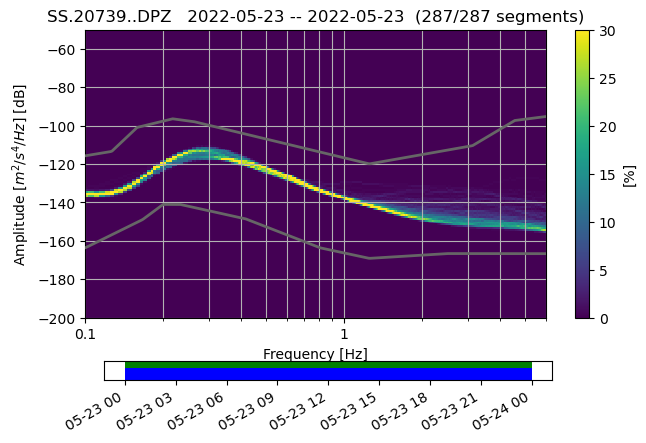

In [25]:
station = '453020739'
ff = obspy.read(rot+'453020739.18.2022.05.23.00.00.00.000.Z.miniseed')
print(ff)
tr = ff.select(id="SS.20739..DPZ")[0]
ppsd = PPSD(tr.stats, paz_counts,ppsd_length=10*60,period_limits=[1/6,10], smoothing_width_octaves=0.125, period_step_octaves=0.0125)
sst = obspy.read(rot+'453020739.18.2022.05.23.00.00.00.000.Z.miniseed')
ppsd.add(sst)
ppsd.plot(period_lim=(0.1,6), xaxis_frequency=True)

### Processing PPSD all the geophones

In [27]:
#S = ['20773', '20781', '20769', '20774', '20739', '20754']
S = ['20732','20736','20740','20742','20746','20750','20751','20753','20755','20756','20759','20760','20762','20768','20780']
#S = ['20773']

startdate = '2022.05.28'
startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
comp = 'Z'
for stt in S :
    station = '4530%s' %(stt)
    #end date
    pdstop = pd.read_csv('./temp_pos_nodes/tilt_%s.csv'%station)
    stop = pdstop['treshold_tilt'][0]
    print("Date d'arrêt : %s" %str(stop))
    #initiliazing the ppsd
    for file in fileroot :
        if file.startswith('4530%s.4'%stt) and file.endswith('.%s.miniseed' %comp) :
            ff = obspy.read(rot+file)
    tr = ff.select(id="SS.%s..DP%s"%(stt, comp))[0]
    #inv =  obspy.read_inventory(rot+'VI.hus..HHZ.D.2022.007')
    print(ff)
    
    ppsd = PPSD(tr.stats, paz_counts,ppsd_length=10*60,period_limits=[0.03,10],smoothing_width_octaves=0.125, period_step_octaves=0.0125) # 10 minutes with overlap of 50%
    
    #doing ppsd and saving
    for day in range(30) :
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.00.00.00.000")
        print('%s.%s.miniseed' %(datetimeStr, comp))
        if date > datetime.datetime.strptime(stop,  "%Y-%m-%d %H:%M:%S") : # - datetime.timedelta(days=1):
            print(True)
            break
        else :
            for file in fileroot :
                #print(file)
                if file.startswith(station) and file.endswith('%s.%s.miniseed' %(datetimeStr, comp)):
                    print(file)
                    stt = obspy.read(rot+file)
                    ppsd.add(stt)
                    print('Done %s' %file)
                    break
    ppsd.save_npz("./ppsd/nodes_vatna/%s_ppsd%s.npz"%(station, comp)) 

Date d'arrêt : 2022-05-29 16:42:13
1 Trace(s) in Stream:
SS.20732..DPZ | 2022-05-30T00:00:00.000000Z - 2022-05-31T00:00:00.000000Z | 250.0 Hz, 21600001 samples
2022.05.28.00.00.00.000.Z.miniseed
453020732.2.2022.05.28.00.00.00.000.Z.miniseed
Done 453020732.2.2022.05.28.00.00.00.000.Z.miniseed
2022.05.29.00.00.00.000.Z.miniseed
453020732.3.2022.05.29.00.00.00.000.Z.miniseed
Done 453020732.3.2022.05.29.00.00.00.000.Z.miniseed
2022.05.30.00.00.00.000.Z.miniseed
True
Date d'arrêt : 2022-06-02 15:00:25
1 Trace(s) in Stream:
SS.20736..DPZ | 2022-05-31T00:00:00.000000Z - 2022-06-01T00:00:00.000000Z | 250.0 Hz, 21600001 samples
2022.05.28.00.00.00.000.Z.miniseed
2022.05.29.00.00.00.000.Z.miniseed
453020736.2.2022.05.29.00.00.00.000.Z.miniseed
Done 453020736.2.2022.05.29.00.00.00.000.Z.miniseed
2022.05.30.00.00.00.000.Z.miniseed
453020736.3.2022.05.30.00.00.00.000.Z.miniseed
Done 453020736.3.2022.05.30.00.00.00.000.Z.miniseed
2022.05.31.00.00.00.000.Z.miniseed
453020736.4.2022.05.31.00.00.00.00

### Loading PPSD

#### Comparing the "lake outburst"

In [33]:
S = ['20773', '20781', '20769', '20774', '20739', '20754']

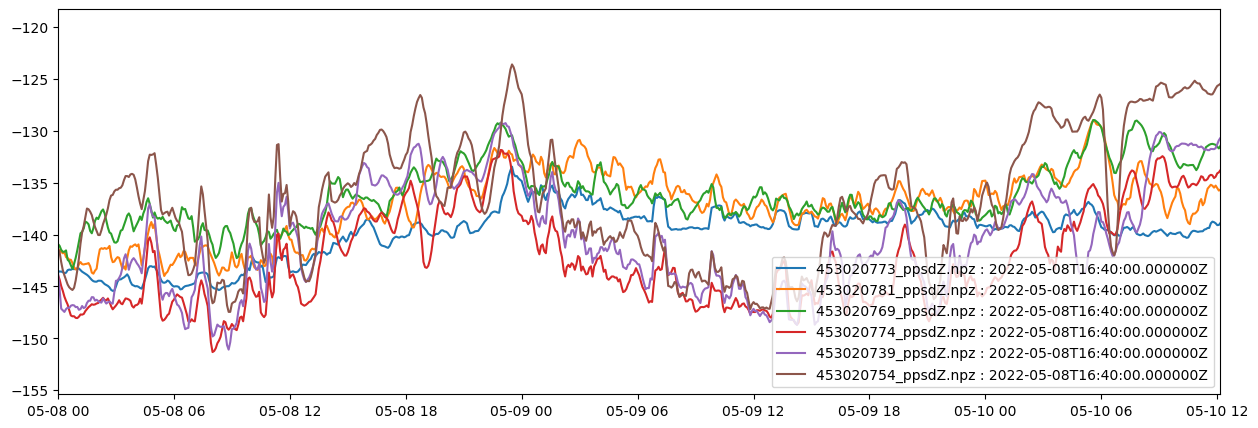

In [ ]:
plt.figure(figsize=(15,5))
for Snpz in S :
    stt = '4530%s_ppsdZ.npz'%Snpz
    ppsd = PPSD.load_npz('./ppsd/%s'%stt)
    Pwater = ppsd.extract_psd_values(1/3)[0]
    Psed = ppsd.extract_psd_values(1/15)[0]
    T = np.array(ppsd.times_processed)
    sPwater = RMS_smoothing(Pwater, T)
    #plt.plot(T[0:500],Pwater[0:500],label='kkk')
    plt.plot(sPwater[3].astype('datetime64[s]'), -sPwater[0],label='%s : %s'%(stt,mT))
    #plt.scatter
    plt.xlim(sPwater[3][0],sPwater[3][720])
plt.legend(loc='lower right')
plt.show()

### Loading the PPSD for specific station

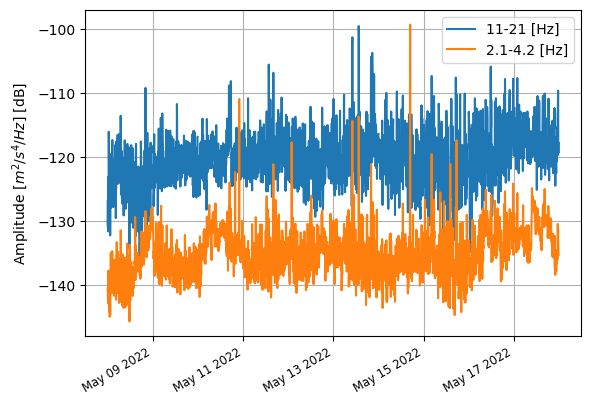

<Figure size 640x480 with 0 Axes>

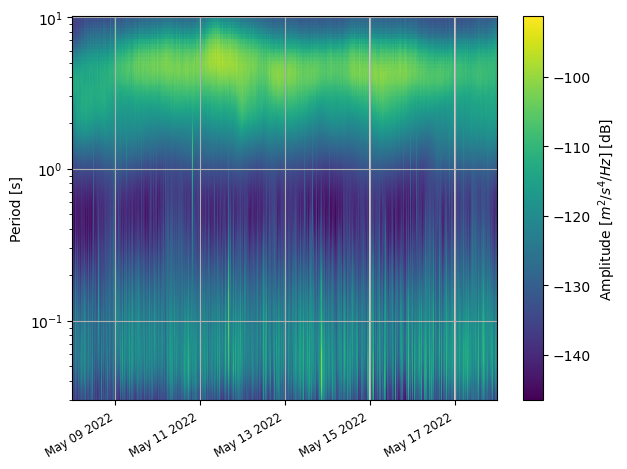

In [55]:
Snpz = '20769'
stt = '4530%s_ppsdZ.npz'%Snpz
ppsd = PPSD.load_npz('./ppsd/%s'%stt)
ppsd.plot_temporal([1/15,1/3])

fig = plt.figure()
ppsd.plot_spectrogram(grid=True)
#plt.ylim(0.05,1)
plt.show()

In [56]:
Pwater =ppsd.extract_psd_values(1/3)[0]
Psed = ppsd.extract_psd_values(1/15)[0]
T = ppsd.times_processed

In [57]:
sPwater = RMS_smoothing(Pwater, T,nbrpt=24)
sPsed = RMS_smoothing(Psed, T,nbrpt=24)
medPwater = medGPS_linear(Pwater, T, nbrpt=8)

[]

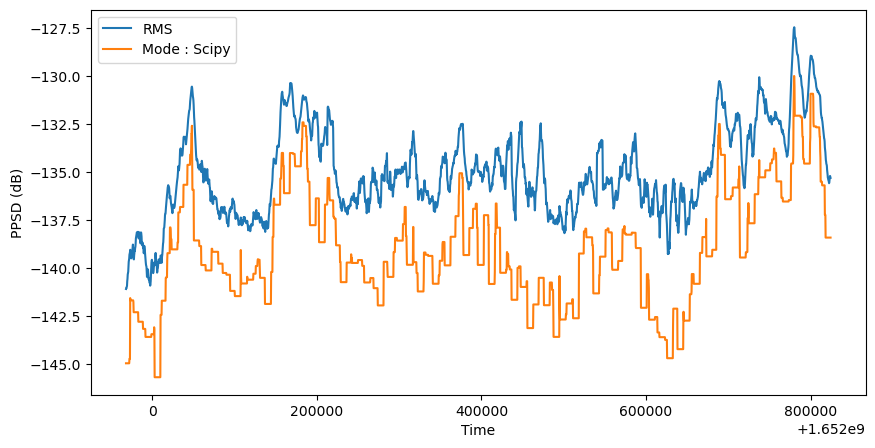

In [58]:
plt.figure(figsize = (10,5))

plt.plot(sPwater[3],-sPwater[0],label='RMS')
plt.plot(sPwater[3], sPwater[1],label='Mode : Scipy')
#plt.plot(sPwater[3], sPwater[2],label='Mode : np.hist')
#plt.plot(T,Pwater, label='RAW')
#plt.plot(medPwater[2],medPwater[0],label='Median')
plt.ylabel('PPSD (dB)')
plt.xlabel('Time')
#plt.ylim(-145,-120)
plt.legend()
plt.plot()

## Determining the Pw and Pb Ratio


In [59]:
len(sPwater[3])

2846

In [60]:
Tdate = np.array(sPwater[3], dtype='datetime64[ms]')
ggtime = np.array(gauging_time, dtype= 'datetime64[ms]')

In [61]:
dt =  240*60000

In [62]:
bintime = np.in1d(ggtime, Tdate+dt)

In [63]:
disPW = np.extract(bintime,gauging_velos)

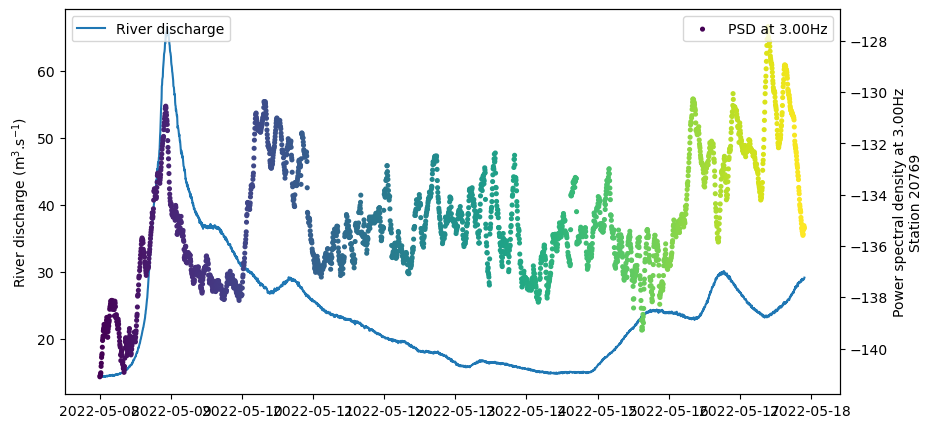

In [64]:
#determine min and max of the lake outburst
idx = int(48*60/5)
MAXP = np.max(-sPwater[0][0:idx])
MINP = np.min(-sPwater[0][0:idx])

idxMAXP = np.argmax(-sPwater[0][0:idx])
idxMINP = np.argmin(-sPwater[0][0:idx])

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(Tdate,disPW, label='River discharge')
plt.legend(loc='upper left')
ax1.set_ylabel('River discharge (m$^3$.s$^{-1}$)')
ax2=ax1.twinx()
ax2.scatter(Tdate,-sPwater[0],c=mdates.date2num(Tdate), s=7, label='PSD at %.2fHz' %(3.0))
#ax2.scatter(Tdate[idxMINP], MINP, marker='+', c='r', s=100)
#ax2.scatter(Tdate[idxMAXP], MAXP, marker='+', c='orange', s=100)

ax2.set_ylabel('Power spectral density at %.2fHz\nStation %s' %(3., Snpz))
plt.legend(loc='upper right')


#ax2.set_ylim(-150,-130)

#plt.savefig('./plot_hydro/Pw_Q_Time_%s.png' %Snpz , bbox_inches='tight')

### Plotting the relatioship between discharge and noise power

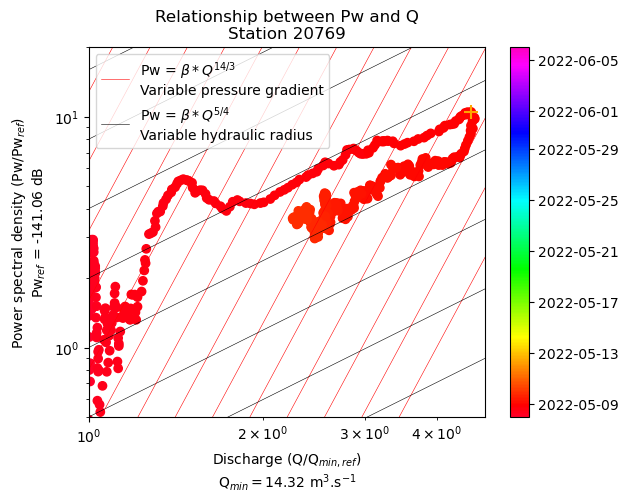

In [65]:
import matplotlib.dates as mdates
import matplotlib.colors as colors

sPw = -sPwater[0]
LQ =  disPW/np.min(disPW)
dd = plt.scatter(LQ[0:550], sPw[0:550]-sPw[np.argmin(disPW)],c=mdates.date2num(Tdate[0:550]))
dd.set_norm(colors.Normalize(vmin=19120.0, vmax=19149.0))
dd.set_cmap('gist_rainbow')


cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
mdates.AutoDateFormatter
L = np.arange(1,70,.1)
i = .0125/(2**4)

np.arange(.2,4000,10)
for j in range(50) :
    #print((.1*i-i/4000))
    i *= 2
    p1 = i*L**(14/3)
    p2 = i*5*L**(5/4)
    a1, = plt.plot(L, p1, c='r',label='Pw = $ \\beta*Q^{14/3}$\nVariable pressure gradient',linewidth=.4)
    a2,= plt.plot(L, p2, c='k',label='Pw = $\\beta*Q^{5/4}$\nVariable hydraulic radius',linewidth=.4)
    
plt.scatter(LQ[idxMINP], MINP-sPw[np.argmin(disPW)], marker='+', c='r', s=100)
plt.scatter(LQ[idxMAXP], MAXP-sPw[np.argmin(disPW)], marker='+', c='orange', s=100)

plt.ylim(.5, 20)
plt.xlim(1,np.max(disPW/np.min(disPW))+.2)
#plt.xlim(-.5, 10)
plt.legend(handles=[a1, a2])
plt.xlabel('Discharge (Q/Q$_{min, ref}$)\nQ$_{min} = %.2f$ m$^3$.s$^{-1}$'  %(np.min(disPW)))
plt.ylabel('Power spectral density (Pw/Pw$_{ref}$)\nPw$_{ref}$ = %.2f dB'%(sPw[np.argmin(disPW)]))
plt.title('Relationship between Pw and Q\nStation %s'%Snpz)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('./plot_hydro/Pw_Q_%s' %Snpz, bbox_inches='tight')
plt.show()


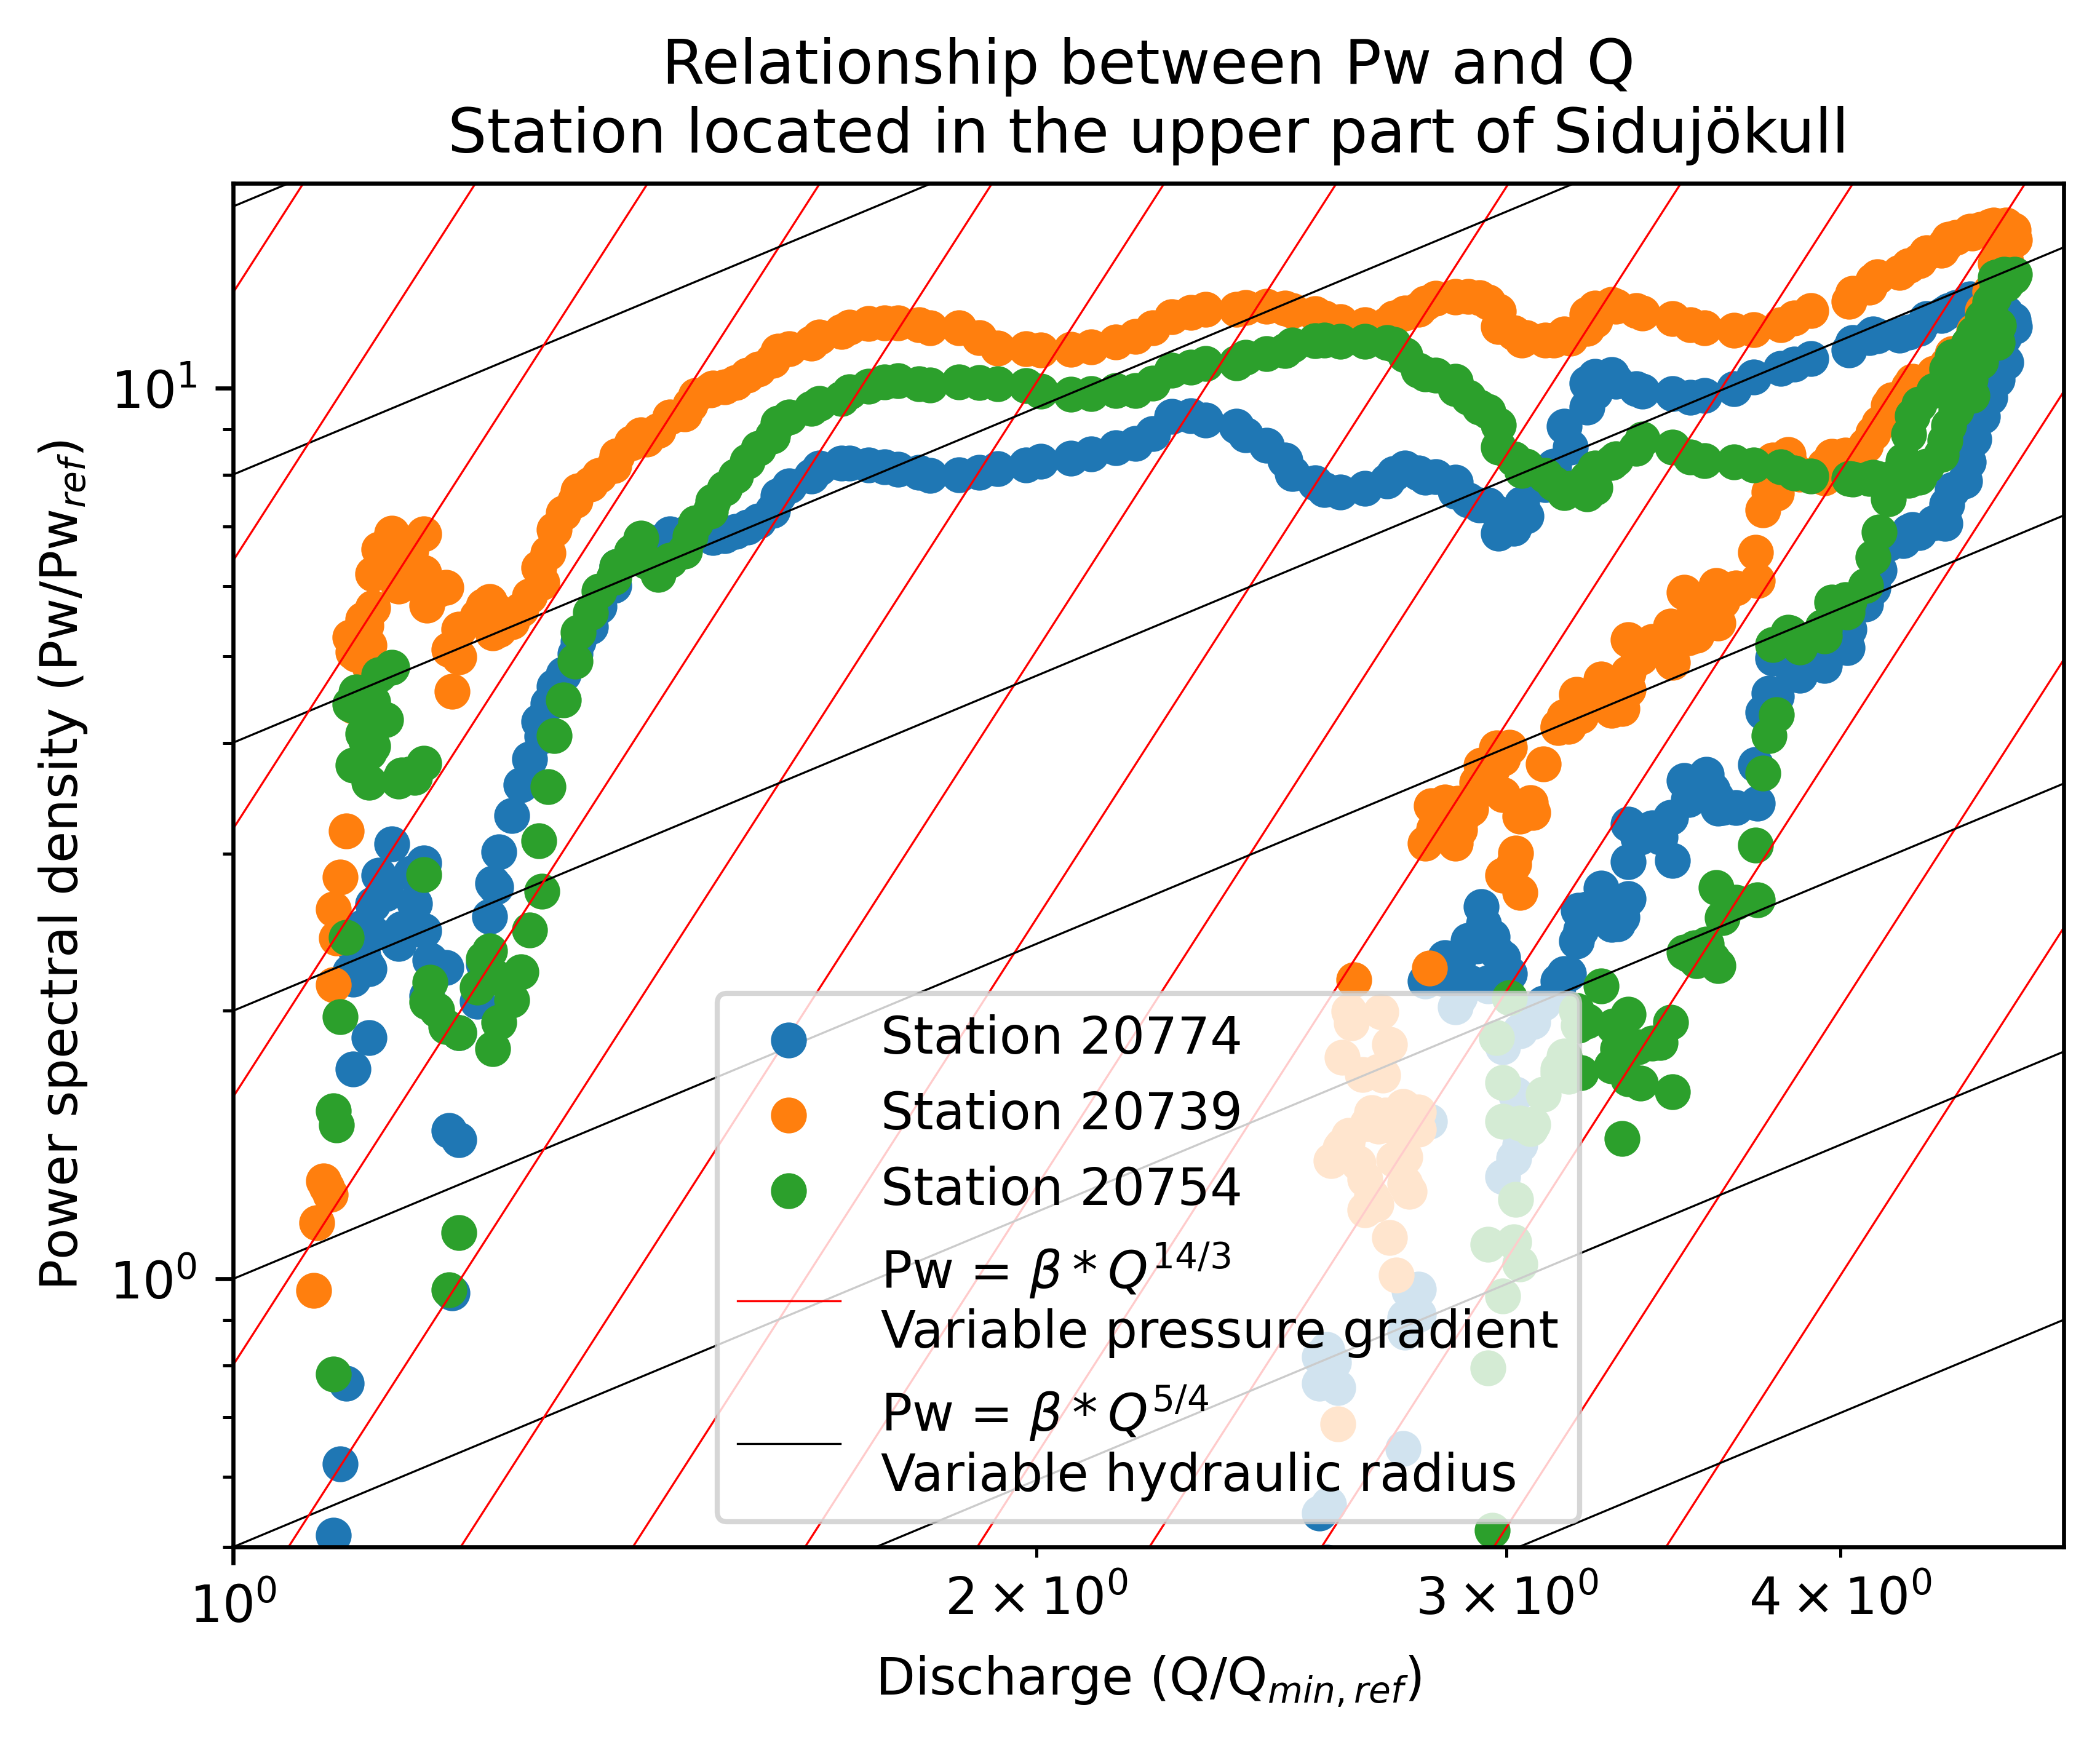

In [101]:
import matplotlib.dates as mdates
import matplotlib.colors as colors

sPw = -sPwater[0]
LQ =  disPW/np.min(disPW)
#dd = plt.scatter(LQ[0:550], sPw[0:550]-sPw[np.argmin(disPW)],c=mdates.date2num(Tdate[0:550]))
#dd.set_norm(colors.Normalize(vmin=19120.0, vmax=19149.0))
#dd.set_cmap('gist_rainbow')

fig = plt.figure(dpi=600)

S = ['20774', '20739', '20754'] #['20773', '20781', '20769']  

for Snpz in S :
    stt = '4530%s_ppsdZ.npz'%Snpz
    ppsd = PPSD.load_npz('./ppsd/%s'%stt)
    Pwater = ppsd.extract_psd_values(1/3)[0]
    Psed = ppsd.extract_psd_values(1/15)[0]
    T = np.array(ppsd.times_processed)
    sPw = RMS_smoothing(Pwater, T,nbrpt=24)
    sPw = -sPw[0]
    #plt.plot(T[0:500],Pwater[0:500],label='kkk')
    dd = plt.scatter(LQ[100:450], sPw[100:450]-sPw[np.argmin(disPW)], label='Station %s' %Snpz)
    #plt.scatter
    #plt.xlim(sPwater[3][0],sPwater[3][720])

#cb = plt.colorbar()
#loc = mdates.AutoDateLocator()
#cb.ax.yaxis.set_major_locator(loc)
#cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
mdates.AutoDateFormatter
L = np.arange(1,70,.1)
i = .0125/(2**4)

np.arange(.2,4000,10)
for j in range(50) :
    #print((.1*i-i/4000))
    i *= 2
    p1 = i*L**(14/3)
    p2 = i*5*L**(5/4)
    txa1 = 'Pw = $ \\beta*Q^{14/3}$\nVariable pressure gradient'
    txa2 = 'Pw = $\\beta*Q^{5/4}$\nVariable hydraulic radius'
    a1, = plt.plot(L, p1, c='r',label=txa1,linewidth=.4)
    a2,= plt.plot(L, p2, c='k',label=txa2,linewidth=.4)

#plt.scatter(LQ[idxMINP], MINP-sPw[np.argmin(disPW)], marker='+', c='r', s=100)
#plt.scatter(LQ[idxMAXP], MAXP-sPw[np.argmin(disPW)], marker='+', c='orange', s=100)

plt.ylim(.5, 17)
plt.xlim(1,np.max(disPW/np.min(disPW))+.2)
#plt.xlim(-.5, 10)
#plt.legend(handles=[a1, a2], loc='upper left')
plt.legend(['Station '+S[0],'Station '+S[1],'Station '+S[2],txa1, txa2], loc='lower center')
plt.xlabel('Discharge (Q/Q$_{min, ref}$)')
plt.ylabel('Power spectral density (Pw/Pw$_{ref}$)')
plt.title('Relationship between Pw and Q\nStation located in the upper part of Sidujökull')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('./plot_hydro/Pw_Q_%s' %Snpz, bbox_inches='tight')
plt.show()


### Plotting the relationship between the noise due to water and sediments

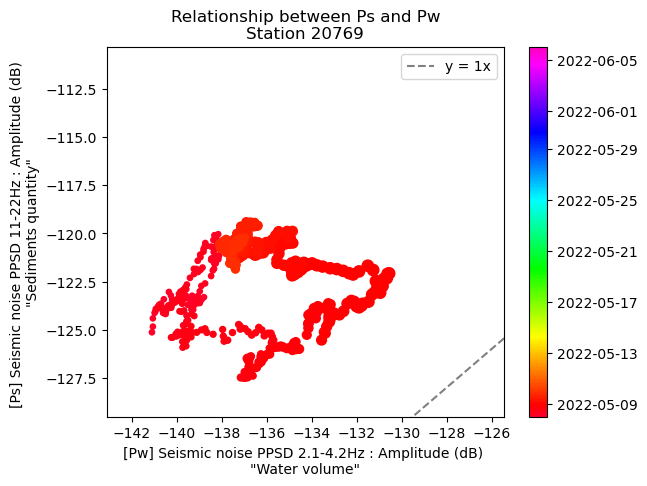

In [71]:
dr = plt.scatter(-sPwater[0][0:550],-sPsed[0][0:550], c=mdates.date2num(Tdate[0:550]), s=disPW[0:550])
dr.set_norm(colors.Normalize(vmin=19120.0, vmax=19149.0))
dr.set_cmap('gist_rainbow')
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.xlabel('[Pw] Seismic noise PPSD 2.1-4.2Hz : Amplitude (dB) \n"Water volume"')
plt.ylabel('[Ps] Seismic noise PPSD 11-22Hz : Amplitude (dB) \n"Sediments quantity"')
plt.plot([-150,-120],[-150,-120], c='grey', linestyle='--', label='y = 1x')
plt.ylim(np.min(-sPsed[0])-2,np.max(-sPsed[0])+2)
plt.xlim(np.min(-sPwater[0])-2,np.max(-sPwater[0])+2)
plt.legend()
plt.title('Relationship between Ps and Pw\nStation %s'%Snpz)
plt.savefig('./plot_hydro/Pw_Ps_%s' %Snpz, bbox_inches='tight')
plt.show()

## 3D plot

Text(0.5, 0, '[Ps] Seismic noise PPSD 11-22Hz : Amplitude (dB) \n"Sediments quantity"')

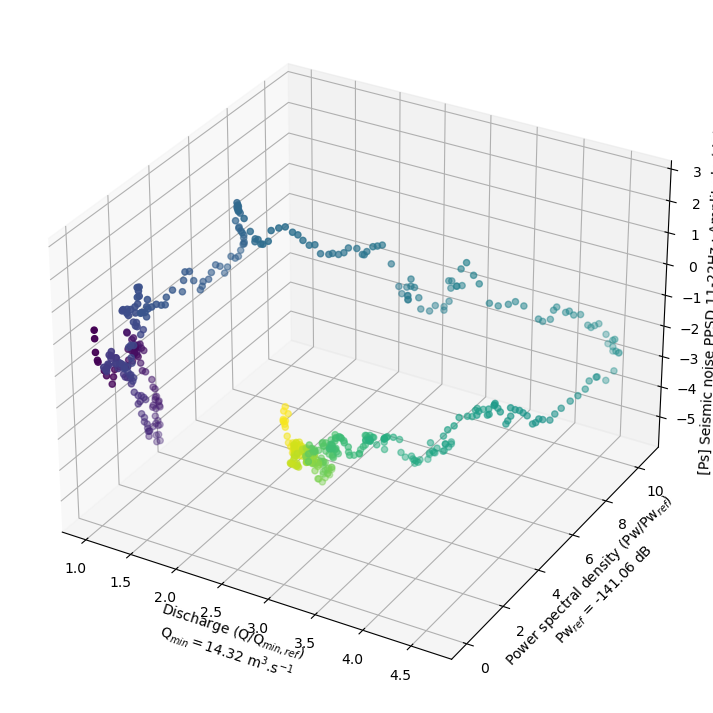

In [87]:
%matplotlib inline

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")


ax.scatter3D(LQ[0:550], sPw[0:550]-sPw[np.argmin(disPW)], sPsed[0][0:550]-sPsed[0][np.argmin(disPW)], 
             c=mdates.date2num(Tdate[0:550]))

ax.set_xlabel('Discharge (Q/Q$_{min, ref}$)\nQ$_{min} = %.2f$ m$^3$.s$^{-1}$'  %(np.min(disPW)))
ax.set_ylabel('Power spectral density (Pw/Pw$_{ref}$)\nPw$_{ref}$ = %.2f dB'%(sPw[np.argmin(disPW)]))
ax.set_zlabel('[Ps] Seismic noise PPSD 11-22Hz : Amplitude (dB) \n"Sediments quantity"')

# Garbage

## Determining the periodicity of the signals
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [365]:
from period_finder import period_temp_discharge_noise

In [211]:
period_temp_discharge_noise(temp, 288, gauging_velos, 288, medianall739, 24*3)

NameError: name 'medianall739' is not defined

In [362]:
#df = pd.read_csv('./temp_pos_nodes/temp_20773.csv')

In [363]:
#temp_time = np.array(df.TIME, dtype='datetime64[ms]')
#temp = np.array(df.TEMPERATURE)

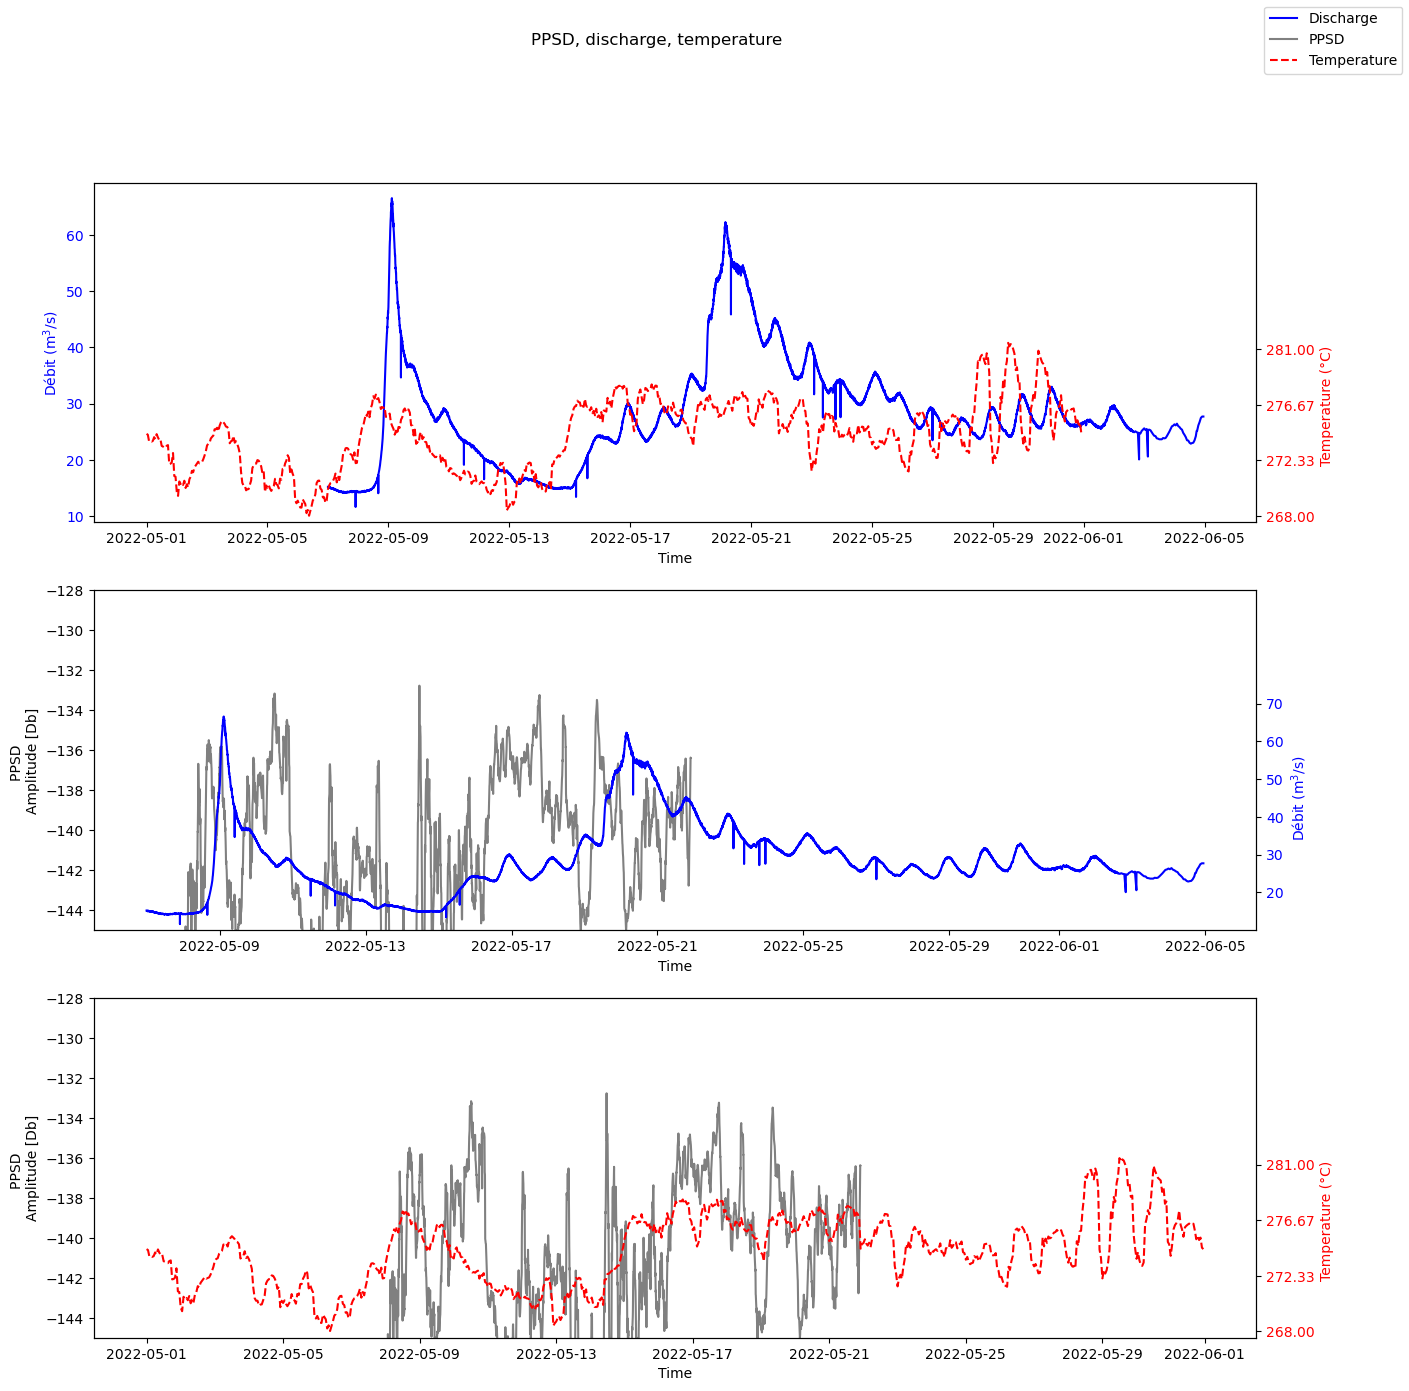

In [375]:
Tdate = np.array(sPwater[3], dtype='datetime64[ms]')
hydronoise_plot(gauging_time, gauging_velos,Tcfd, TEMP, Tdate, -sPwater[0], limit=(-145,-128), Yax_noise='PPSD \nAmplitude [Db]')